# Discrete-time optimal control through dynamic programming

We consider a discrete-time system modelled by 
$$
\mathbf x_{k+1} = \mathbf f_k(\mathbf x_k,\mathbf u_k),\quad k\in[i,N],\quad \mathbf x_i = \text{given}.
$$

Our task is to find the sequence $\mathbf{u}_{i},\mathbf{u}_{i+1},\ldots,\mathbf{u}_{N-1}$ that minimizes the performance index
$$
J_i(\mathbf x_i,\mathbf{u}_{i},\mathbf{u}_{i+1},\ldots,\mathbf{u}_{N-1}) = \phi(x_N,N) + \sum_{k=i}^{N-1}L_k(x_k,u_k)
$$
for a given initial state $\mathbf x_i$. That is, our task is to find
$$
J_i^*(\mathbf x_i) := \min_{\mathbf{u}_{i},\mathbf{u}_{i+1},\ldots,\mathbf{u}_{N-1}} J_i(\mathbf x_i,\mathbf{u}_{i},\mathbf{u}_{i+1},\ldots,\mathbf{u}_{N-1}) 
$$


The key result that we are going to apply is the celebrated Bellman's principle of optimality

$$\boxed{
J_k^*(\mathbf x_k) = \min_{\mathbf u_k}\left[L_k(\mathbf x_k,\mathbf u_k) + J_{k+1}^*(\mathbf x_{k+1})\right]
}
$$

## Scalar case (first-order state-space system)

If we want to apply dynamic programming the the problem of discrete-time optimal control, we need to discretize (grid, quantize) the $x$ axis too. But then we are going to need interpolations later. That is why we need to load the [Interpolations](https://github.com/JuliaMath/Interpolations.jl) package first.

In [1]:
using Interpolations

### Building the lookup table using Bellman's principle

The code for filling in two look-up tables—one for the optimal cost and the other for the optimal control—is below wrapped into a function. The names of the function arguments correspond to our formulas above.

In [2]:
function design_dp_lookup_tables(f,ϕ,L,x,u,N)
    n = length(x)                           # number of grid points for x
    m = length(u)                           # number of grid points for u
    Js = Matrix{Number}(undef,n,N+1)        # allocation of the table for J*
    Us = Matrix{Number}(undef,n,N)          # allocation of the table for u*
    for i=1:n                               # evaluating the cost at the final time
        Js[i,N+1] = ϕ(x[i])                 # (N+1)-th column corresponds to J at k=N
    end
    for k=N:-1:1                            # iterating over time, but k=N is for time N-1
        Jsintp = LinearInterpolation(x,Js[:,k+1])   # preparing for interpolations
        for i=1:n                           # iterating over grid points in the x space
            Ju = Vector{Number}(undef,m)    # unstarred J for the individual discretized u
            for j=1:m                       # iterating over grid points in the u space
                xnext = f(x[i],u[j])        # prediction of the next state
                if xnext>x[1] && xnext<x[end]     # detects if inside the range
                    Ju[j] = L(x[i],u[j]) + Jsintp(xnext)
                else
                    Ju[j] = Inf
                end
            end
            Js[i,k] = minimum(Ju)
            Us[i,k] = isfinite(Js[i,k]) ? u[argmin(Ju)] : NaN
        end
    end
    return Js, Us                           # return the two lookup tables: J* and U*
end

design_dp_lookup_tables (generic function with 1 method)

Discrete-time state-space model of the system

In [3]:
a = -4/3
b = 2

f(x,u) = a*x + b*u

f (generic function with 1 method)

Specifying the cost function - a quadratic function ccomposed of the terminal cost and the running cost

In [4]:
sN = 5
q = 2
r = 1

ϕ(xN) = 1/2*sN*xN^2
L(x,u) = 1/2*(q*x^2 + r*u^2)

L (generic function with 1 method)

Gridding the allowed state space the control space

In [5]:
x = -3:0.1:3
u = -0.5:0.1:0.5

-0.5:0.1:0.5

The length of the time interval 

In [6]:
N = 15

15

Creating the lookup tables invoking the Bellman's principle of optimality 

In [7]:
Js,Us = design_dp_lookup_tables(f,ϕ,L,x,u,N)

(Number[Inf Inf … Inf 22.5; 73.45159168813275 73.3460645762071 … 29.084999999999983 21.025; … ; 73.45159168813282 73.34606457620717 … 29.084999999999994 21.025; Inf Inf … Inf 22.5], Number[NaN NaN … NaN NaN; -0.5 -0.5 … -0.5 -0.5; … ; 0.5 0.5 … 0.5 0.5; NaN NaN … NaN NaN])

Before moving on, it is certainly interesting to have a look at the lookup table for the optimal cost function $J^*$ for all the grid values of the state variable $x$ at a given (discrete) time

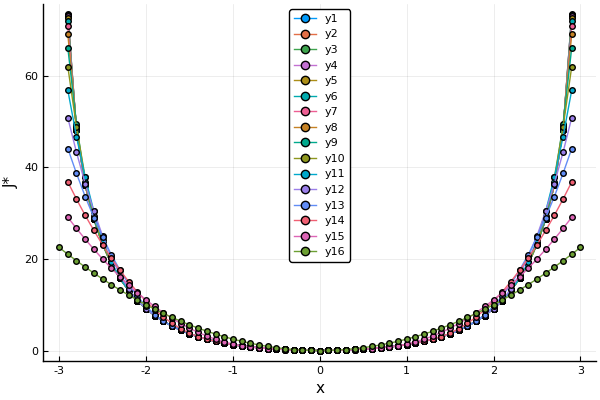

In [8]:
using Plots
pyplot()

plot(x,Js,markershape=:circ)
xlabel!("x")
ylabel!("J*")

These shapes of cost functions corresponding to invididual discrete times are not quite suprising. From our previous investigation of the LQR problem using indirect methods, we know that the cost function at a given time is a quadratic function of the state (defined as a quadratic matrix form with the matrix $S$ obtained by solving a Riccati equation). Our functions look quadratic-ish too, don't they? For a linear system and a quadratic cost, the only reason for their deviation from true quadratic functions are the imposed lower and upper bounds on the control.

You are encouraged to experiment with some nonlinear dynamics too—just change the definition of `f` function above and possibly the two terms in the cost function.

### Simulate the response with the controller in the loop

Let's now simulate a response of the system with our new state feedback controller to some nonzero initial condition (nonzero initial state). The controller now comes in the form of a lookup table characterized by the array `U` of optimal control values and the grid of the state variable  

In [9]:
function dpsim(a,b,U,xgrid,x0,N)
    x = Vector{Float64}(undef, N+1)                 # prepares an array for state response
    u = Vector{Float64}(undef, N)                   # prepares an array for controls
    x[1] = x0
    for k=1:N                                       # remember the [0,N-1] -> [1,N] shift
        uintp = LinearInterpolation(xgrid,U[:,k])
        u[k] = uintp(x[k])                          # interpolation in the look-up table
        x[k+1] = a*x[k] + b*u[k]
    end
    return x, u
end

dpsim (generic function with 1 method)

Choose the initial state

In [10]:
x0 = 2.5

2.5

Now simulate the response to the initial state (while employing the feedback regulator)

In [11]:
xsim, usim = dpsim(a,b,Us,x,x0,N)

([2.5, -2.333333333333333, 2.1111111111111107, -1.814814814814814, 1.4197530864197518, -0.8930041152263357, 0.19067215363511414, -0.05422953818015214, -0.0361530254534351, -0.024102016968956752, -0.016068011312638283, -0.01071200754175873, -0.007141338361172419, -0.004760892240781465, -0.003173928160520937, -0.0021159521070137736], [0.5, -0.5, 0.5, -0.5, 0.5, -0.5, 0.1, -0.054229538180152304, -0.03615302545343511, -0.024102016968956974, -0.01606801131263822, -0.010712007541758696, -0.007141338361172345, -0.004760892240781445, -0.003173928160520845])

### Plot the simulation responses

Finally, plot the state response and the produced control sequence

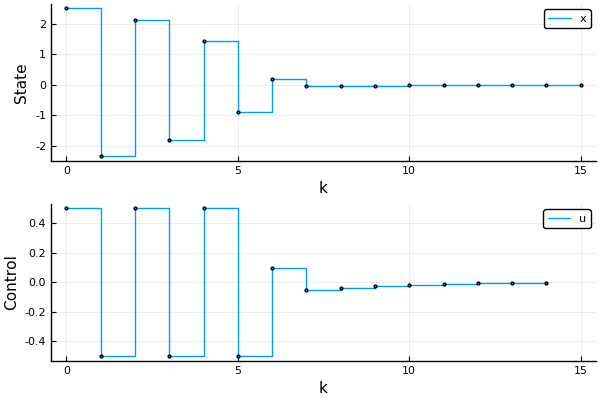

In [12]:
p1 = plot(0:N,xsim,markershape=:circ,markersize=2,linetype=:steppost,label="x")
xlabel!("k")
ylabel!("State")

p2 = plot(0:N-1,usim,markershape=:circ,markersize=2,linetype=:steppost,label="u",xlims=xlims(p1))
xlabel!("k")
ylabel!("Control")

plot(p1,p2,layout=(2,1))

## References

[1] Lewis, Frank, Draguna Vrabie, and Vassilis L. Syrmos. Optimal Control. 3rd edition. Hoboken: Wiley, 2012.